In [1]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

## Load and split data

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '../DATA/landscapeImages/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
      
    img = cv2.imread(path + '/'+i,1)
    # open cv reads images in BGR format so we have to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    color_img.append(img_to_array(img))


gray_img = []
path = '../DATA/landscapeImages/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    img = cv2.imread(path + '/'+i,1)

    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    gray_img.append(img_to_array(img))

100%|██████████| 7129/7129 [00:02<00:00, 2661.69it/s]


In [3]:
# train split 
len_data = len(color_img)
train_size = int(len_data*0.8)

train_gray_image = gray_img[:train_size]
train_color_image = color_img[:train_size]

test_gray_image = gray_img[train_size:]
test_color_image = color_img[train_size:]

train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (5703, 160, 160, 3)
Test color image shape (1426, 160, 160, 3)


## Predictions

### Prediction ResNet18

In [4]:
#load the model
model = keras.models.load_model('final_models/resnet18AE_mod_lr001.h5')

#predict the images
preds_r18 = model.predict(test_gray_image)

45/45 [==============================] - 6s 67ms/step


### Prediction ResNet34

In [5]:
#load the model
model = keras.models.load_model('final_models/resnet34AE_mod_lr001.h5')

#predict the images
preds_r34 = model.predict(test_gray_image)

45/45 [==============================] - 4s 78ms/step


### Prediction ResNet50

In [6]:
#load the model
model = keras.models.load_model('final_models/resnet50AE_mod_lr001.h5')

#predict the images
preds_r50 = model.predict(test_gray_image)

45/45 [==============================] - 10s 159ms/step


## Metrics

In [7]:
# ssim from skimage
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, preds):
    ssim_val = []
    for i in range(original.shape[0]):
        ssim_val.append(ssim(original[i], preds[i], multichannel = True, data_range=1.0, channel_axis=2))
    return ssim_val

In [8]:
def get_metrics_eval(test_x_image, preds, model_name):
    ssim_val = calculate_ssim(test_x_image, preds)
    mse = tf.keras.losses.mean_squared_error(tf.convert_to_tensor(test_x_image), tf.convert_to_tensor(preds))
    mae = tf.keras.losses.mean_absolute_error(tf.convert_to_tensor(test_x_image), tf.convert_to_tensor(preds))
    psnr = tf.image.psnr(tf.convert_to_tensor(test_x_image), tf.convert_to_tensor(preds), 1.0)

    mean_ssim = np.mean(ssim_val)
    mean_mse = tf.reduce_mean(mse).numpy()
    mean_mae = tf.reduce_mean(mae).numpy()
    mean_psnr = tf.reduce_mean(psnr).numpy()

    std_ssim = np.std(ssim_val)
    std_mse = tf.math.reduce_std(mse).numpy()
    std_mae = tf.math.reduce_std(mae).numpy()
    std_psnr = tf.math.reduce_std(psnr).numpy()

    output = f"Model: {model_name}\t"
    output += f"SSIM: {mean_ssim:.4f}\u00B1{std_ssim:.4f}\t"
    output += f"MSE: {mean_mse:.4f}\u00B1{std_mse:.4f}\t"
    output += f"MAE: {mean_mae:.4f}\u00B1{std_mae:.4f}\t"
    output += f"PSNR: {mean_psnr:.4f}\u00B1{std_psnr:.4f}\n"
    # 4 decimals
    print(output)

In [9]:
get_metrics_eval(test_gray_image, preds_r18, "ResNet18")
get_metrics_eval(test_gray_image, preds_r34, "ResNet34")
get_metrics_eval(test_gray_image, preds_r50, "ResNet50")

Model: ResNet18	SSIM: 0.9388±0.0358	MSE: 0.0044±0.0079	MAE: 0.0437±0.0347	PSNR: 25.0975±3.5601

Model: ResNet34	SSIM: 0.9445±0.0369	MSE: 0.0036±0.0068	MAE: 0.0396±0.0317	PSNR: 25.9111±3.5242

Model: ResNet50	SSIM: 0.9530±0.0274	MSE: 0.0032±0.0060	MAE: 0.0392±0.0299	PSNR: 26.2480±3.2317



In [10]:
def get_metric_image(original, predicted):
    ssim_value = ssim(original, predicted, multichannel = True, data_range=1.0, channel_axis=2)
    psnr = tf.image.psnr(tf.convert_to_tensor(original), tf.convert_to_tensor(predicted), 1.0).numpy()

    return round(ssim_value, 4), round(psnr,4)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def display(indices, language='en'):
    rows = len(indices)
    columns = 5

    fig, axs = plt.subplots(rows, columns, figsize=(16, 18))
    
    for i, index in enumerate(indices):
        original = test_color_image[index]
        gray_scale = test_gray_image[index]
        resnet18 = preds_r18[index]
        resnet34 = preds_r34[index]
        resnet50 = preds_r50[index]
        
        axs[i, 0].imshow(original)
        axs[i, 0].axis('off')
        # axs[i, 0].set_title('Original')

        axs[i, 1].imshow(gray_scale)
        axs[i, 1].axis('off')
        ssim_val, psnr_val = get_metric_image(original, gray_scale)
        axs[i, 1].text(0.5, -0.1, f"SSIM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 1].transAxes)

        axs[i, 2].imshow(np.clip(resnet18, 0, 1))
        axs[i, 2].axis('off')
        ssim_val, psnr_val = get_metric_image(original, resnet18)
        axs[i, 2].text(0.5, -0.1, f"SSIM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 2].transAxes)

        axs[i, 3].imshow(resnet34)
        axs[i, 3].axis('off')
        ssim_val, psnr_val = get_metric_image(original, resnet34)
        axs[i, 3].text(0.5, -0.1, f"SSIM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 3].transAxes)

        axs[i, 4].imshow(resnet50)
        axs[i, 4].axis('off')
        ssim_val, psnr_val = get_metric_image(original, resnet50)
        axs[i, 4].text(0.5, -0.1, f"SISM: {ssim_val:.4f}\nPSNR: {psnr_val:.4f}", 
                       fontsize=12, ha='center', va='top', transform=axs[i, 4].transAxes)


        
    # Añadir texto centrado debajo de cada columna
    if language == 'en':
        column_titles = [
            "Original",
            "Gray Scale",
            "ResNet18",
            "ResNet34",
            "ResNet50",
        ]
    else:
        column_titles = [
            "Original",
            "Escala de Grises",
            "ResNet18",
            "ResNet34",
            "ResNet50",
        ]

    for col in range(columns):
        # Obtener la posición media de la columna en coordenadas normalizadas
        mid = axs[0, col].get_position().x0 + axs[0, col].get_position().width / 2
        fig.text(
            mid,      # posición x centrada para cada columna
            0.89,      # posición y ajustada fuera de las imágenes
            column_titles[col], 
            ha='center', va='center', fontsize=20
        )

    plt.subplots_adjust(hspace=0.3)
    plt.show()


In [12]:
# list of 5 random indices
indices = list(np.random.choice(test_gray_image.shape[0], 5))
indices

[1, 390, 145, 389, 504]

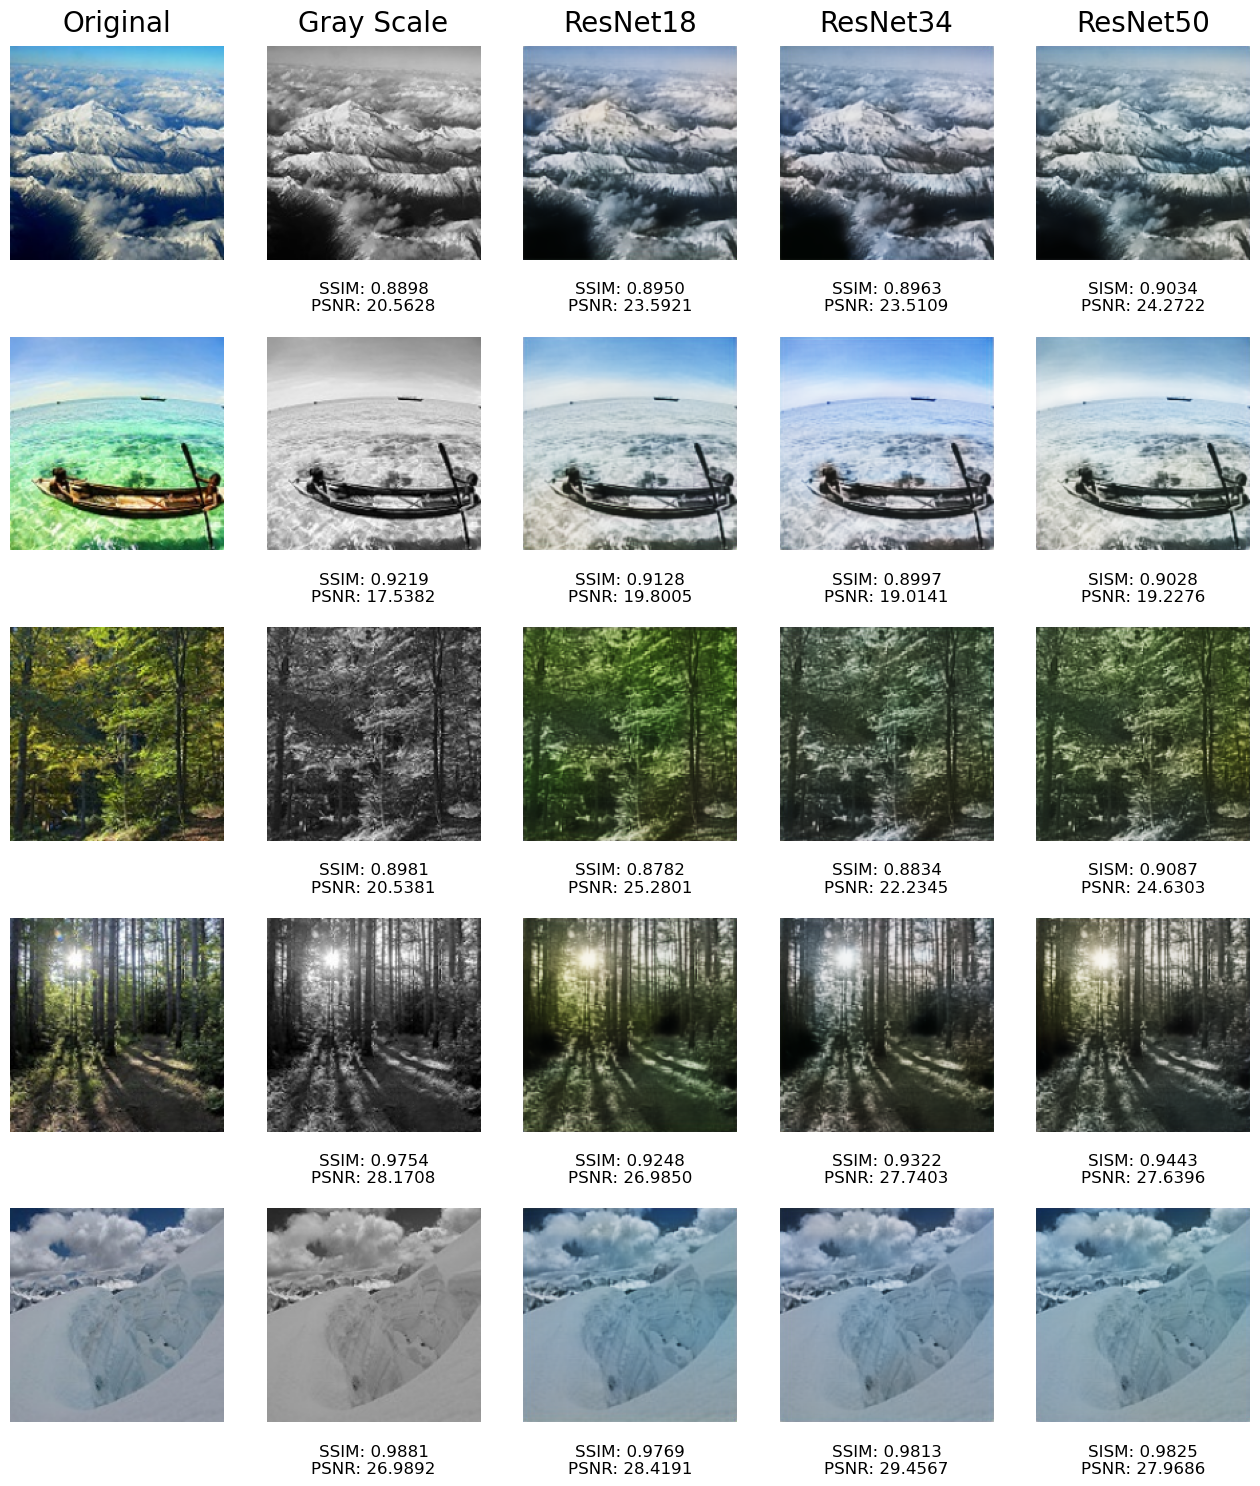

In [13]:
display(indices)

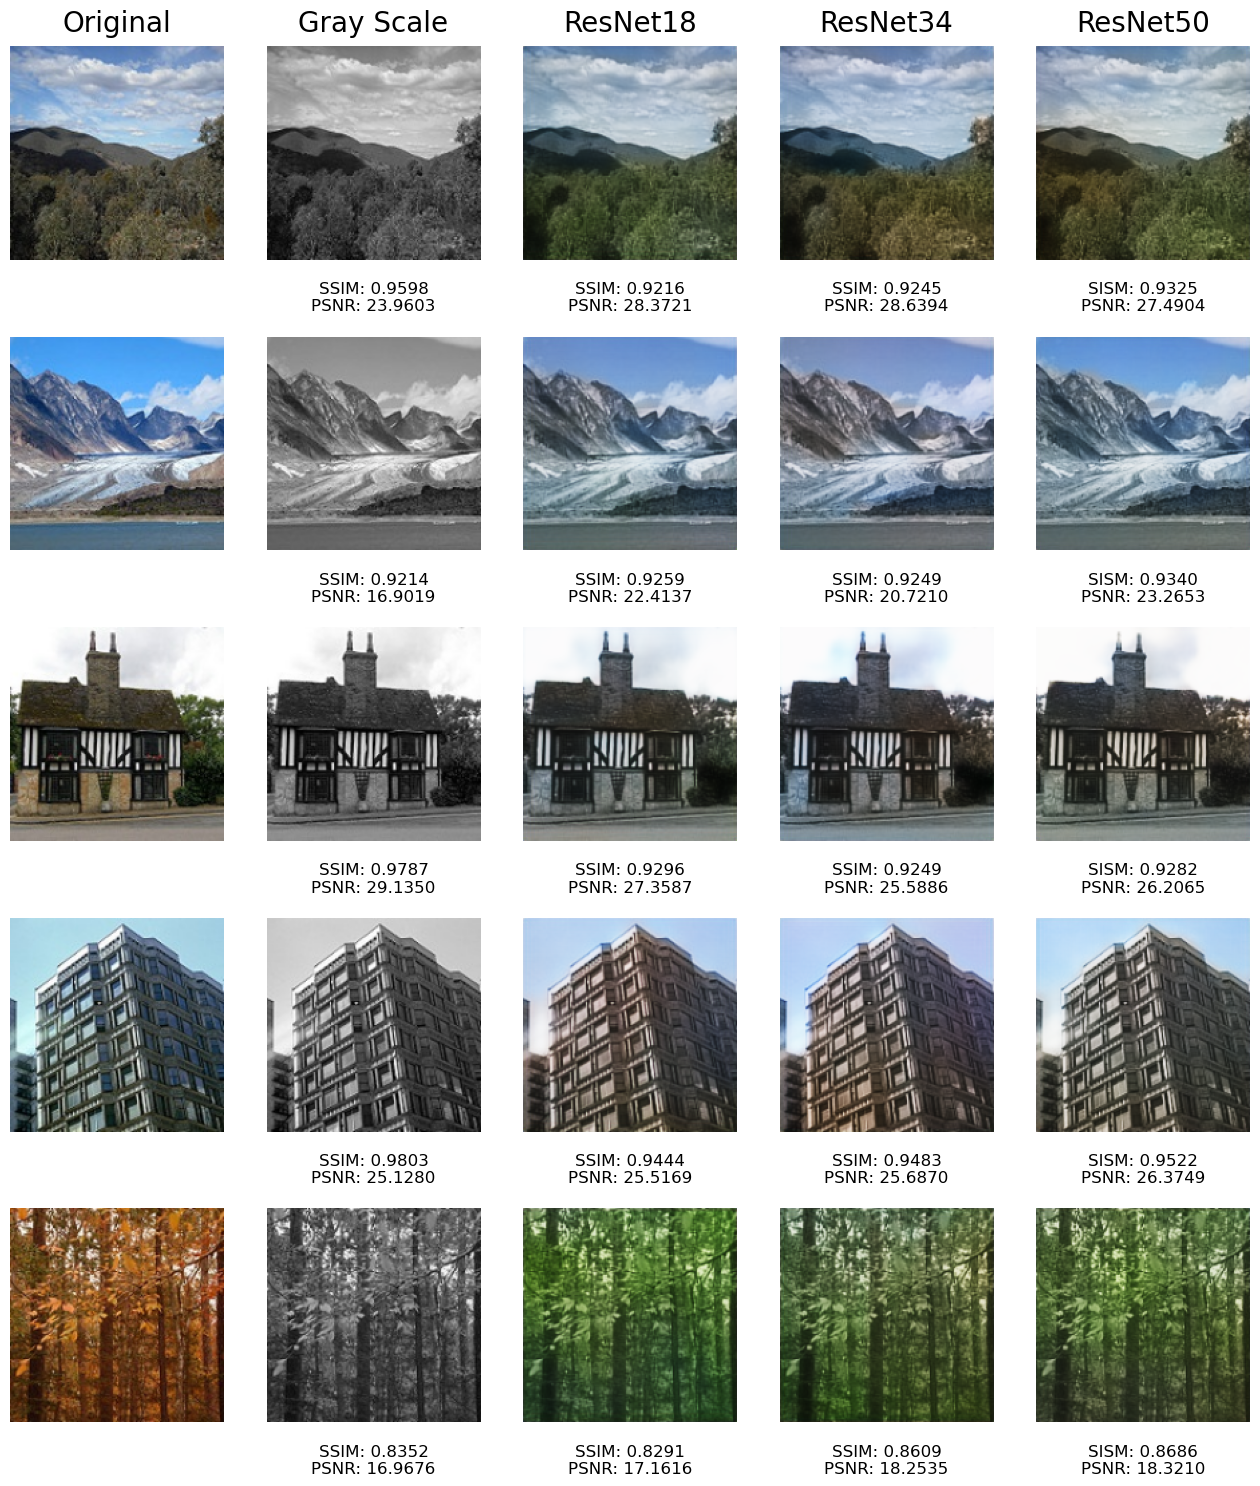

In [14]:
display([916,1029,1420,816,62])

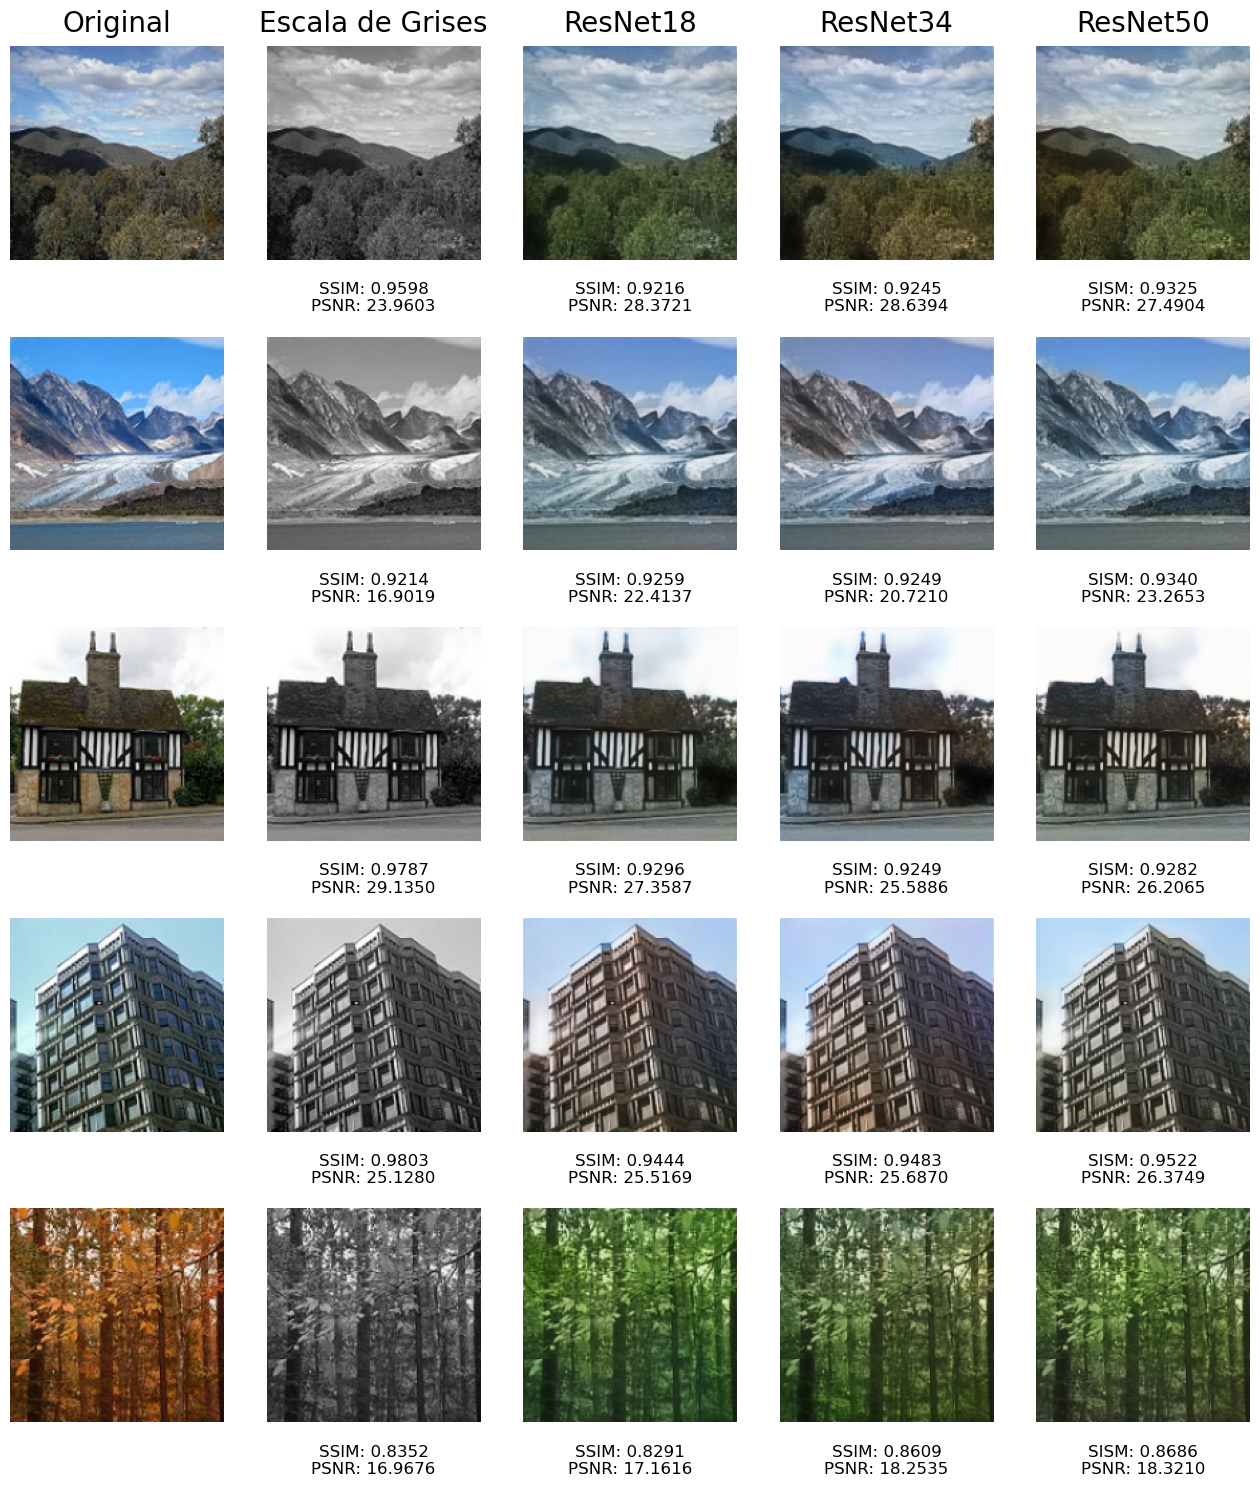

In [15]:
display([916,1029,1420,816,62], "es")